In [1]:
import torch
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional

In [2]:
# --- 1. Centralisation des Paramètres ---

@dataclass
class OTConfig:
    """
    Configuration centralisée pour le transport optimal.
    """

    # Résolution de travail (la grille de calcul)
    resolution: int = 32

    # Échelle de flou (Blur).
    # Doit être > 1/resolution (ex: > 0.03 pour 32x32).
    # Contrôle la "localité" du transport.
    blur: float = 0.05

    # Scaling GeomLoss (Précision du solver)
    scaling: float = 0.9

    # Contrainte Unbalanced (Reach).
    # None = Balanced (Conservation stricte).
    # Float = Unbalanced (Autorise variation de masse).
    reach: Optional[float] = None

    # Exposant du coût (2 = distance euclidienne au carré -> Wasserstein-2)
    p: int = 2

    # Device de calcul
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # parametre du gaussian rasterize
    sigma: float = None

In [3]:
# --- 2. Utilitaires de Mesures & Rasterization ---

def get_measures_from_image(img: torch.Tensor, res: int):
    """Convertit une image en mesures de probabilité sur grille [0,1]^2."""
    C, H, W = img.shape

    # Downsampling propre
    scale = res / max(H, W)
    new_H, new_W = int(H * scale), int(W * scale)

    if new_H != H or new_W != W:
        img = F.interpolate(
            img.unsqueeze(0), size=(new_H, new_W), mode="bilinear", align_corners=False
        ).squeeze(0)

    # Grille normalisée
    y = torch.linspace(0, 1, new_H, device=img.device)
    x = torch.linspace(0, 1, new_W, device=img.device)
    yy, xx = torch.meshgrid(y, x, indexing="ij")

    positions = torch.stack([xx, yy], dim=-1).reshape(-1, 2)  # (N, 2)
    weights = img.reshape(C, -1)  # (C, N)

    # Stabilisation numérique (évite log(0))
    weights = weights.clamp(min=1e-7)

    # Normalisation (Essentiel pour Sinkhorn)
    total_mass = weights.sum(dim=1, keepdim=True)
    weights_normalized = weights / total_mass

    return positions, weights_normalized, new_H, new_W, total_mass


def gaussian_rasterize(positions, weights, H, W, sigma=0.7):
    """
    Rasterization par "Splatting Gaussien".
    Plus robuste aux trous (tearing) que le bilinéaire lors des expansions.

    sigma : Rayon de la tache (en pixels).
            0.5 = très net (risque de trous)
            1.0 = très doux (bouche les trous, mais un peu flou)
    """
    device = positions.device
    N = positions.shape[0]

    # Coordonnées en pixels
    pos_pixel = positions * torch.tensor([W - 1, H - 1], device=device)

    # On définit une fenêtre autour de chaque point (ex: 3x3 pixels)
    # Pour sigma ~ 0.7, 3 sigmas = 2.1 pixels -> rayon de 2 ou 3 suffit
    radius = int(3 * sigma + 1)

    # Grille locale pour le noyau
    # On va itérer sur les offsets (dx, dy) autour du centre entier
    img = torch.zeros((H, W), device=device)

    # Coordonnées entières centrales
    x_c = torch.round(pos_pixel[:, 0]).long()
    y_c = torch.round(pos_pixel[:, 1]).long()

    # Constante de normalisation gaussienne (simplifiée car on veut conserver la masse)
    # On veut que sum(weights_gauss) ~ 1 pour un point isolé loin des bords
    # Mais ici on projette des masses, donc on pondère par l'exponentielle

    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            # Coordonnées voisines
            x_k = x_c + dx
            y_k = y_c + dy

            # Masque pour rester dans l'image
            valid_mask = (x_k >= 0) & (x_k < W) & (y_k >= 0) & (y_k < H)

            if not valid_mask.any():
                continue

            # Calcul du poids gaussien : exp( -dist^2 / (2*sigma^2) )
            # Distance au carré entre la position réelle (float) et le pixel (entier)
            dist_sq = (pos_pixel[:, 0] - x_k.float()) ** 2 + (
                pos_pixel[:, 1] - y_k.float()
            ) ** 2
            gauss_weight = torch.exp(-dist_sq / (2 * sigma**2))

            # On applique uniquement sur les valides
            idx_valid = torch.where(valid_mask)[0]

            # Index linéaire pour l'image
            linear_idx = y_k[idx_valid] * W + x_k[idx_valid]

            # Accumulation : Poids particule * Intensité Gaussienne
            val_to_add = weights[idx_valid] * gauss_weight[idx_valid]

            # Normalisation approximative pour conserver l'énergie (optionnel mais mieux)
            # Pour un splatting simple "bouche-trou", on peut omettre la normalisation stricte
            # tant que sigma est calibré, ou normaliser par 2*pi*sigma^2 si besoin.
            # Ici on normalise empiriquement par un facteur pour éviter la sur-brillance
            val_to_add = val_to_add / (2 * 3.14159 * sigma**2)

            img.view(-1).index_add_(0, linear_idx, val_to_add)

    return img

def bilinear_rasterize(positions, weights, H, W):
    """
    Projette un nuage de points (masses) sur une grille image via interpolation bilinéaire.
    positions : (N_particles, 2) dans [0, 1]
    weights   : (N_particles,)
    Output    : (H, W) image accumulée
    """
    device = positions.device

    # Mise à l'échelle vers les coordonnées pixels
    # On vise les centres des pixels, donc échelle W-1
    pos_pixel = positions * torch.tensor([W - 1, H - 1], device=device)

    # Coordonnées entières (top-left)
    x0 = torch.floor(pos_pixel[:, 0]).long()
    y0 = torch.floor(pos_pixel[:, 1]).long()

    # Clamping pour rester dans l'image
    x0 = torch.clamp(x0, 0, W - 2)
    y0 = torch.clamp(y0, 0, H - 2)

    x1 = x0 + 1
    y1 = y0 + 1

    # Poids bilinéaires
    wa = (x1.float() - pos_pixel[:, 0]) * (y1.float() - pos_pixel[:, 1])
    wb = (x1.float() - pos_pixel[:, 0]) * (pos_pixel[:, 1] - y0.float())
    wc = (pos_pixel[:, 0] - x0.float()) * (y1.float() - pos_pixel[:, 1])
    wd = (pos_pixel[:, 0] - x0.float()) * (pos_pixel[:, 1] - y0.float())

    # Accumulation (Scatter Add)
    img = torch.zeros((H, W), device=device)

    # Index linéaire pour scatter
    idx00 = y0 * W + x0
    idx01 = y0 * W + x1
    idx10 = y1 * W + x0
    idx11 = y1 * W + x1

    img.view(-1).index_add_(0, idx00, weights * wa)
    img.view(-1).index_add_(0, idx01, weights * wb)
    img.view(-1).index_add_(0, idx10, weights * wc)
    img.view(-1).index_add_(0, idx11, weights * wd)

    return img

In [4]:
# --- 3. Moteur de Transport et Interpolation ---


class WassersteinInterpolator:
    def __init__(self, config: OTConfig):
        self.cfg = config
        self.epsilon = config.blur**config.p

        # Solver GeomLoss
        self.loss_layer = SamplesLoss(
            loss="sinkhorn",
            p=config.p,
            blur=config.blur,
            reach=config.reach,
            debias=False,  # False requis pour reconstruire le plan pi exact
            potentials=True,  # Requis pour avoir f et g
            scaling=config.scaling,
            backend="tensorized",
        )

    def compute_coupling_and_interpolate(
        self, img_source, img_target, times: List[float]
    ):
        """
        Génère une séquence d'images interpolées aux temps t donnés.
        """
        # 1. Préparation
        pos_a, w_a, Ha, Wa, mass_a = get_measures_from_image(
            img_source.to(self.cfg.device), self.cfg.resolution
        )
        pos_b, w_b, Hb, Wb, mass_b = get_measures_from_image(
            img_target.to(self.cfg.device), self.cfg.resolution
        )

        # Batch expansion pour RGB
        C = w_a.shape[0]
        pos_a_batch = pos_a.unsqueeze(0).expand(C, -1, -1).contiguous()
        pos_b_batch = pos_b.unsqueeze(0).expand(C, -1, -1).contiguous()

        # 2. Résolution Sinkhorn (Potentiels)
        # F: (C, Na), G: (C, Nb)
        F_pot, G_pot = self.loss_layer(w_a, pos_a_batch, w_b, pos_b_batch)

        results = []

        # 3. Boucle sur les temps t
        for t in times:
            if t == 0.0:
                results.append(img_source.cpu())
                continue
            # if t == 1.0 and self.cfg.reach is None:  # Optimisation Balanced
            #     results.append(img_target.cpu())
            #     continue

            # Interpolation de masse
            # En Unbalanced, la masse totale évolue. En Balanced, elle est constante.
            # Approximation simple : interpolation linéaire des masses totales
            current_total_mass = (1 - t) * mass_a + t * mass_b

            reconstructed_channels = []

            # Traitement canal par canal (permet le morphing de couleur)
            for c in range(C):
                # Récupération des données du canal
                f, g = F_pot[c], G_pot[c]  # (Na,), (Nb,)
                wa_c, wb_c = w_a[c], w_b[c]  # (Na,), (Nb,)
                xa, xb = pos_a, pos_b  # (Na, 2), (Nb, 2)

                # --- Reconstruction Explicite du Plan pi ---
                # C_ij = ||x_i - y_j||^p
                dist = torch.cdist(xa, xb, p=2)
                C_matrix = (
                    (dist**self.cfg.p) / self.cfg.p
                    if self.cfg.p != 2
                    else (dist**2) / 2
                )

                # pi_ij = exp( (f_i + g_j - C_ij) / epsilon ) * a_i * b_j
                # Calcul en log-domain pour stabilité
                log_pi = (
                    (f[:, None] + g[None, :] - C_matrix) / self.epsilon
                    + torch.log(wa_c[:, None])
                    + torch.log(wb_c[None, :])
                )

                # On filtre les poids négligeables pour accélérer et nettoyer
                # (Optionnel mais recommandé pour splatting)
                pi = torch.exp(log_pi)

                # --- Déplacement Géodésique (Displacement Interpolation) ---
                # Position des particules à l'instant t : z_ij(t) = (1-t)x_i + t y_j
                # Broadcasting: (Na, 1, 2) + (1, Nb, 2) -> (Na, Nb, 2)
                pos_t = (1 - t) * xa[:, None, :] + t * xb[None, :, :]

                # Aplatissement pour le rasterizer
                flat_weights = pi.view(-1)
                flat_pos = pos_t.view(-1, 2)

                # Rasterization (Splatting) sur la grille cible
                channel_img = (
                    gaussian_rasterize(
                        flat_pos, flat_weights, Hb, Wb, sigma=self.cfg.sigma
                    )
                    if self.cfg.sigma
                    else bilinear_rasterize(
                        flat_pos, flat_weights, Hb, Wb
                    )
                )

                # Remise à l'échelle d'intensité
                channel_img = channel_img * current_total_mass[c]
                reconstructed_channels.append(channel_img)

            # Assemblage RGB
            img_t = torch.stack(reconstructed_channels, dim=0)
            results.append(img_t.cpu())

        return results

--- Pipeline OT lancé sur cuda ---
Unbalanced with reach=0.1
Blur: 0.03, Res: 64, sigma: 0.3


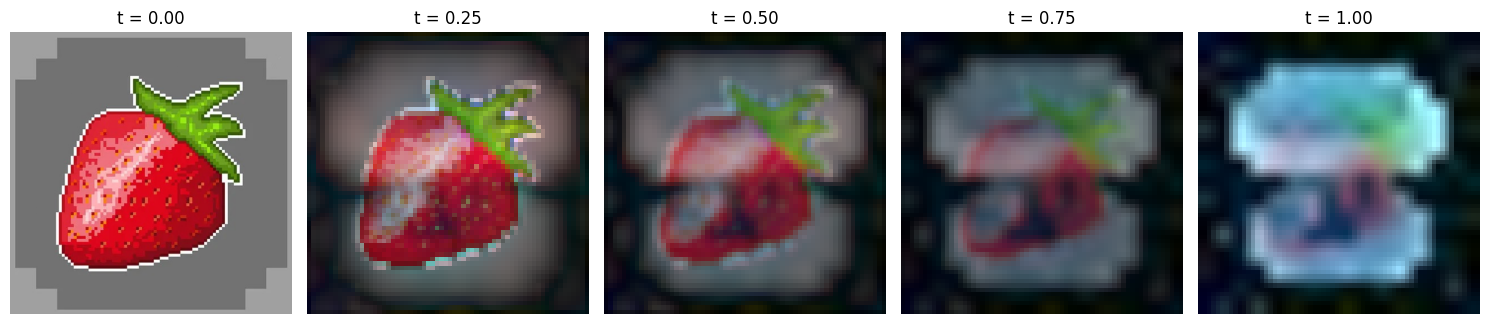

In [9]:
# --- 4. Exécution (Paramètres Modifiables) ---

# ================= CONFIGURATION =================
CONFIG = OTConfig(
    resolution=64,  # Résolution de calcul (grille OT)
    blur=0.03,  # Doit être > 1/resolution (~0.03)
    reach=0.1,  # None = Balanced, Valeur (ex: 0.2) = Unbalanced
    p=2,  # Wasserstein-2
    sigma= 0.3
)

# Liste des temps d'interpolation [0 -> 1]
INTERPOLATION_TIMES = [0.0, 0.25, 0.5, 0.75, 1.0]
# =================================================


def main():
    print(f"--- Pipeline OT lancé sur {CONFIG.device} ---")
    if CONFIG.reach is None:
        print(f"Mode: Balanced")
    else:
        print(f"Unbalanced with reach={CONFIG.reach}")
    print(f"Blur: {CONFIG.blur}, Res: {CONFIG.resolution}, sigma: {CONFIG.sigma}")

    # 1. Chargement (Dummy ou Fichier)
    try:
        # Remplacez par vos chemins
        img1_pil = Image.open("/home/janis/4A/geodata/data/pixelart/images/strawberry.jpg").convert("RGB")
        img2_pil = Image.open("/home/janis/4A/geodata/data/pixelart/images/image_241.JPEG").convert("RGB")
    except:
        print("Images non trouvées, génération synthétique...")
        img1_pil = Image.fromarray(np.zeros((32, 32, 3), dtype=np.uint8))
        img2_pil = Image.fromarray(np.zeros((32, 32, 3), dtype=np.uint8))
        # Dessin rapide pour tester
        pixels1 = img1_pil.load()
        pixels2 = img2_pil.load()
        for i in range(10, 22):
            for j in range(10, 22):
                pixels1[i, j] = (255, 0, 0)  # Carré rouge centre
        for i in range(5, 15):
            for j in range(20, 30):
                pixels2[i, j] = (0, 0, 255)  # Carré bleu décalé

    # Conversion Tensor
    img1 = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1).float() / 255.0
    img2 = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1).float() / 255.0

    # 2. Calcul de l'interpolation
    interpolator = WassersteinInterpolator(CONFIG)
    frames = interpolator.compute_coupling_and_interpolate(
        img1, img2, INTERPOLATION_TIMES
    )

    # 3. Affichage
    n_frames = len(frames)
    plt.figure(figsize=(3 * n_frames, 4))

    for i, frame in enumerate(frames):
        t = INTERPOLATION_TIMES[i]
        plt.subplot(1, n_frames, i + 1)

        # Conversion pour affichage
        np_img = frame.permute(1, 2, 0).clamp(0, 1).numpy()

        plt.imshow(np_img)
        plt.title(f"t = {t:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()